
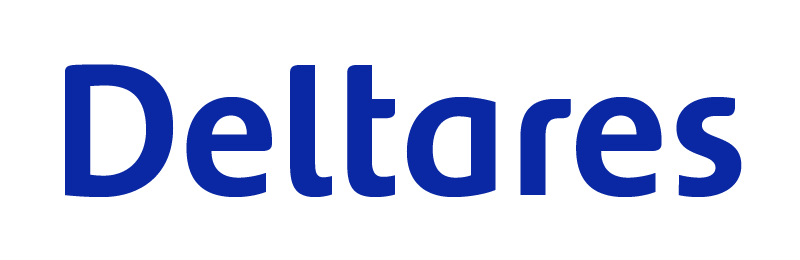

# Import and edit MODFLOW 6 modeldata and analysis

## Installation

For this tutorial the packages iMOD Python (v0.18.1), pandamesh and jupyter are
required. To save yourself a lot of hassle, we advice installing with pixi.

### 1. Install pixi
We will install

[See link here](https://pixi.sh/latest/). On Windows, you can run in Powershell:

```powershell
iwr -useb https://pixi.sh/install.ps1 | iex
```

or in cmd.exe:

```batch
winget install prefix-dev.pixi
```

Pixi has the following advantages:

1. Solves dependencies faster than conda/pip
2. Saves the exact state of your environment in a textfile, which you can
   use to exactly reproduce results from a project.
3. Install packages from conda-forge and PyPI


### 2. Navigate to your folder

In the terminal, navigate to the folder with the tutorial material.

```powershell
cd /path/to/your/tutorial/folder.
```

TIP: To save time, if you have Windows Explorer open, you can hold 
SHIFT + Right Click, and click "Copy As Path" from the context menu to get the path.
You can then paste this in your terminal window (right click, or CTRL+V)

### 3. Activate pixi environment

Now activate environment, this will also install a python environmen in the
``.pixi`` folder. You can delete this after finishing the tutorial.

```powershell
pixi shell
```

### 4. Start the jupyter notebook

```powershell
jupyter notebook 
```

## Tutorial Description

In this tutorial, you will learn how to use iMOD Python for building, running
and analysing your MODFLOW 6 model. We compiled a tutorial to help you get
started with iMOD Python and give you an overview of some of its capabilities.

In this Tutorial you learn how to:
1. load an existing model from a project file;
1. run your model;
1. view you results;
1. add your additional data for rivers;
1. allocate your rivers to the right model layer(s);
1. validate your model;
1. clean up your modeldata;
1. rescale to coarser grid.

Extra options: 
1. create an unstructured grid with Pandamesh
1. "regrid you model to an unstructured mesh"

## Handle Jupyter notebook

We run this tutorial in a Jupyter notebook. You can run this cell by cell:
- ``[]`` means the cell is not run yet,
- ``[*]`` means the cell is currently running,
- ``[1]`` means the cell is finished.
- Click the Run button to go from cell to cell


**Note**: The cells where we run the simulation can take several seconds or even minutes.



# Introduction case Hondsrug

The "Hondsrug" a Dutch ridge of sand over a range of 70 km. It is the only
*geopark* in The Netherlands and part of Natura 2000, an European network of
protected areas. <br>

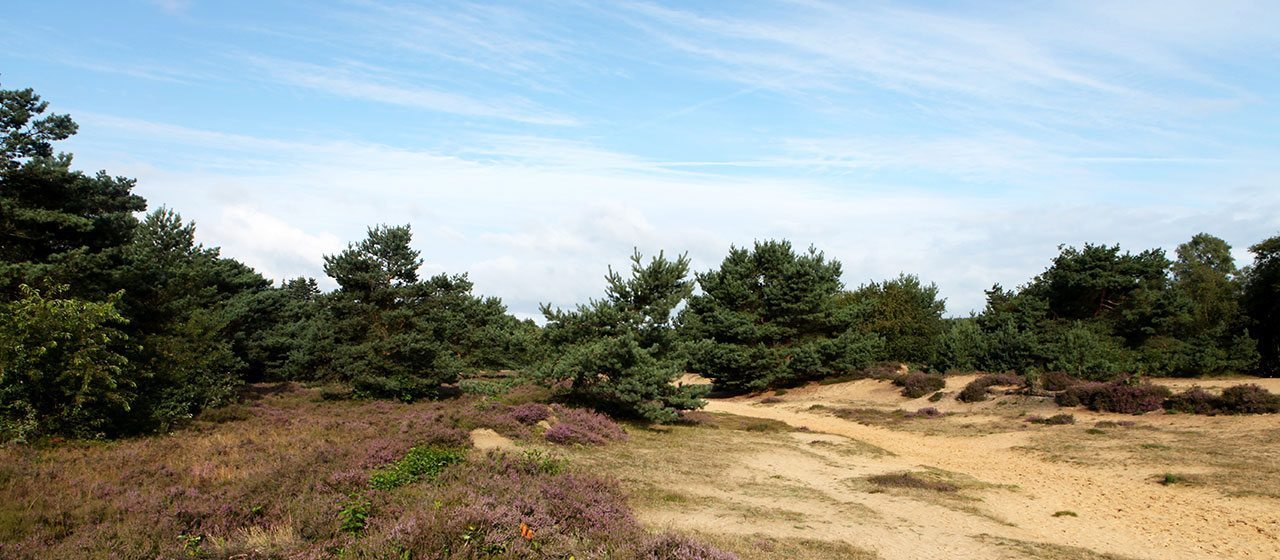

# Start of the iMOD python tutorial

We'll start off with importing iMOD Python. Therefore type ``import imod`` in
the next cell and run it.

In [4]:
import imod


From now on, all iMOD Python functions and classes are available. An important
one is the class ``imod.mf6.Modflow6Simulation``. An object from this class
can contain one or more complete MODFLOW 6 models. For more MODFLOW 6
functions and classes check the [API Reference
website](https://deltares.gitlab.io/imod/imod-python/api/mf6.html#)



## Read simulation from iMOD5 project file (*.prj)

For the past years, iMOD Python mainly has been a library to build models in scripts from scratch. The 0.12.0 version introduced a [``dump`` method](https://deltares.github.io/imod-python/api/generated/mf6/imod.mf6.Modflow6Simulation.dump.html) that allows you to dump MODFLOW6 simulations to a set of netcdfs and toml, and read these again with ``from_file``. [See the earlier tutorial here.](https://deltares.github.io/iMOD-Documentation/tutorial_Hondsrug.html#)

However, there exist many iMOD5 models, for which we'd like to offer some backwards compatibility. Therefore recently, since version 0.18.0, it is possible to import iMOD5 models into python. 
These iMOD5 models use a PRJ file as model configuration file and *.IDF and *.IPF files for data. <br>
You find the PRJ file for this tutorial in the tutorial database named *"... tuturial_03\GWF_model_Hondsrug.prj".* <br>

To get there, let's first set the current working directory. 
(we will import the package ``pathlib`` first.) 

In [5]:
from pathlib import Path
tutorialdir = Path(r"./tutorial_03")


Now we are ready to have a quick look at the content of this model configuration file. <br> Good to know: 
- iMOD5 uses 1 file per parameter, per layer and per timestep. 
While the Hondsrug model is a 13 layer model, you will recognize date blocks for 13 layers.
- **Nota bene:** The model in the project file *must* be fully 3D. Quasi-3D models, which only have horizontal flow in aquifers, and vertical flow in aquitards are not supported.

In the next cell, open the PRJ file in a new window.

In [6]:
# location of PRJ file in your Tutorial folder
PRJname = tutorialdir / "GWF_model_Hondsrug.prj"
# Open the PRJ file in Notepad
!notepad {PRJname}

You recognize Modflow input parameters like *Boundary Condition*, *Top* and *Bottom Elevation* and further down also *Rivers*. <br>

Close the window of "GWF_model_Hondsrug.prj". <br> 
*(For more information on the PRJ file, download the [iMOD5 manual](https://content.oss.deltares.nl/imod/imod56/iMOD_User_Manual_V5_6.pdf) 
and check chapter "9.3 PRJ-files")* <br>

We will use the iMOD Python function ``prj.open_projectfile_data`` to load this MODFLOW 6 model from the
PRJ file. <br> This returns a Python dictionary, so in memory, with all the basic data from the PRJ file.

In [7]:
imod5_data, period_data = imod.prj.open_projectfile_data(PRJname)

Let's check the content of *imod5_data*. We skip *period_data*. It is empty in this example because no time periods are defined. <br> 
*imod5_data* is a Python dictionary, so we can ask for the ``keys``, the table of contents of this dictionary. <br>
Than you will see that the DRN is defined by 3 systems and RIV by 4.

In [71]:
imod5_data.keys()

dict_keys(['bnd', 'top', 'bot', 'khv', 'kva', 'shd', 'sto', 'rch', 'drn-1', 'drn-2', 'drn-3', 'drn-4', 'riv', 'pcg'])

You are going to edit one of these packages later on. <br> 

Be aware that this dictionary can contain raster data for various xy-windows and with different cell size. <br>
The next step is to use this basic data and transform it into a real *Modflow6Simulation object*. <br> 
That transformation is a complex process. It includes all kinds of regridding, clipping, masking and vertical auto-placement features that the iMOD5 executable provided before. <br>

For this transformation we use the iMOD Python function ``Modflow6Simulation.from_imod5_data``. <br>
The function requires these settings:   
1. a definition of the time discretization of the model to be imported (specific for the WELL package) 
1. (default) allocation options per package type
1. (default) conductivity distribution options per package type

Let's define these 3 settings first:

In [9]:
# definition of stress periods
import numpy as np
starttime = "2011-01-01"
endtime = "2013-01-01"
times=[np.datetime64(starttime),np.datetime64(endtime)]

## Transform iMOD5 model data into a MODFLOW6 simulation

Now we are ready to create the *Modflow6Simulation object* from the iMOD5 data. You are free to assign it to variable name of your choice, we will call the simulation "sim_Hondsrug" here.

In [10]:
sim_Hondsrug = imod.mf6.Modflow6Simulation.from_imod5_data(imod5_data, period_data, times)

We are almost ready to write and run the MODFLOW6 model. <br>
Last step is to define what results we want to save in the Output Control settings. 

In [11]:
# Define the required output parameters
sim_Hondsrug["imported_model"]["oc"] = imod.mf6.OutputControl(save_head="last", save_budget="last")

Let's see what is in this *Modflow6Simulation object* by just typing the name of the object.

In [12]:
sim_Hondsrug

Modflow6Simulation(
    name='imported_simulation',
    directory=None
){
    'imported_model': GroundwaterFlowModel,
    'ims': Solution,
    'time_discretization': TimeDiscretization,
}

Let's describe what we see in the print statement of ``sim_Hondsrug``: 
- it is a Modflow6Simulation object
- the simulation contains a Groundwater Flow (GWF) model
- the name of the GWF is 'imported_simulation'


## Running the MODFLOW 6 simulation

Now it's time to run the MODFLOW 6 simulation. This takes a few minutes.
1. First, we define a result folder, the name of your model run.
1. Then we write the MODFLOW 6 input file, so the mfsim.nam file and all other package input files.
1. Finally we run the model with the MODFLOW 6 executable.

By default the model is saved and run in a temporal directory. Feel free to give a foldername of your choice. <br>
With a simple ``.write`` statement the native MODFLOW6 files are written. This might take some 10-15 seconds.

In [13]:
# 1. define the results folder
resultdir = tutorialdir / "results" / "reference"
# 2. write the MODFLOW6 input files
sim_Hondsrug.write(resultdir)

Now we can refer to the MODFLOW6 executable and start the simulation.

In [14]:
# define path of your MODFLOW 6 executable
mf6= tutorialdir / "bin" / "MODFLOW6_v6.4.2.exe" 

# Run your model (this will take some time)
sim_Hondsrug.run(mf6.resolve())

The model is ready but did it run correctely? <br>
Always check the MODFLOW6 log file "mfsim.lst". <br> See if it exists and if the last line reads ``Normal termination of simulation``.

In [78]:
LSTname = resultdir / "mfsim.lst"
!notepad {LSTname}

Don't forget to close the Notepad window. Otherwise you can not continue. <br> 
In case the indicator in front of this cell keeps telling ``In [*]`` than your Notepad window is still open somewhere. 


Like to see one of the calculated Heads before we continue? <br>
Then we must import all Heads with the function ``.open_head()`` that is available within the simulation object "sim_Hondsrug". <br> For the enthusiast; this function uses ``imod.mf6.open_hds`` on the background.

In [79]:
hds = sim_Hondsrug.open_head()

This *hds* is an multidimensional xarray with Heads for all layers and all timesteps. <br> Type the name of this array and Python gives a nice info graphic of the content.  


In [80]:
hds

<xarray.DataArray 'head' (time: 3, layer: 13, y: 200, x: 500)> Size: 31MB
dask.array<stack, shape=(3, 13, 200, 500), dtype=float64, chunksize=(1, 13, 200, 500), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 4kB 2.375e+05 2.375e+05 2.376e+05 ... 2.5e+05 2.5e+05
  * y        (y) float64 2kB 5.64e+05 5.64e+05 5.639e+05 ... 5.59e+05 5.59e+05
    dx       float64 8B 25.0
    dy       float64 8B -25.0
  * layer    (layer) int64 104B 1 2 3 4 5 6 7 8 9 10 11 12 13
  * time     (time) float64 24B 365.0 730.0 1.096e+03

Befor we can use different plot functions, we must first import the package ``matplotlib``.

In [81]:
import matplotlib.pyplot as plt

Now we can plot the Head of a single layer and a specific stressperiod.<br>
Did you see that we have results for 3 times and 13 layers? <br>
Let's plot the Heads of layer 3 and the 3rd timestep. 

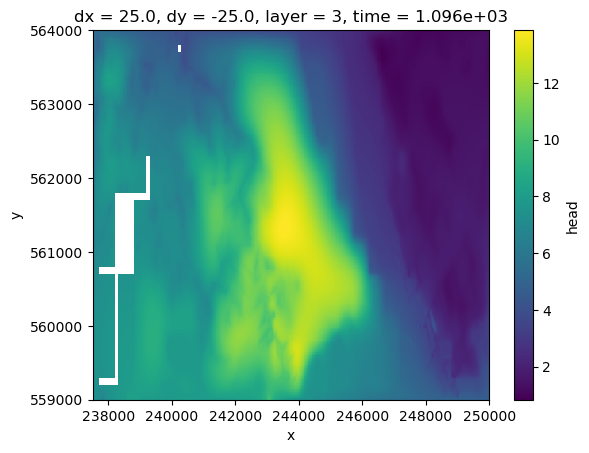

In [83]:
fig, ax = plt.subplots()
hds.sel(layer=3).isel(time=2).plot(ax=ax)

> Intermezzo: counting in Python <br>
> Yes, that is correct, we selected layer 3 and the 3rd timestep with ``hds.sel(layer=3).isel(time=2)``. <br>
> Didn't we  mistype 2 and 3? No. This is why:
> - in xarray you can make a selection based on label with ``.sel`` or based on index with ``.isel``. <br>
> - in the real world counting (the index) starts with 1. Python is a different world. The index starts with 0. You will get used to it.
> - layers are labeled 1,2....,13 so with ``.sel`` we can select the corresponding *label*. In this case the label is "3"
> - times are labeled with a specific datetime (e.g. 2024-11-20). Finding the correct label can be difficult. So we prefer to select by index. And the 3rd timestep is index 3.

> So you can imagine you get the same picture with this command ``hds.isel(layer=2).sel(time=1096.).plot(ax=ax)``. <br>
> Try it. 


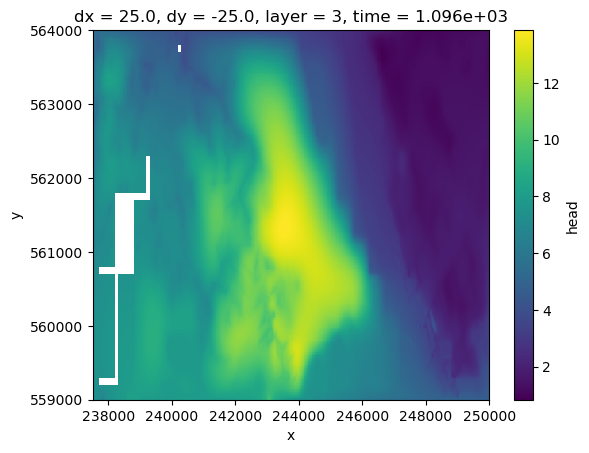

In [84]:
# same figure, different selection method
fig, ax = plt.subplots()
hds.isel(layer=2).sel(time=1096.).plot(ax=ax)

That's it for this modelrun. Let's continue with another feature: validation.

## Validation of “new, better” river data

This must sound familiar to you: during the development or maintenance of your ground water model you might receive new river data from a colleague. <br>
In the next step we show you:
- how to import that new data, 
- how you can validate it and
- if necessary, apply a data clean up.

In the next step the examples data is downloaded from the iMOD Python installation.

In [85]:
#gwf_model = gwf_simulation["GWF"]
tmpdir = imod.util.temporary_directory()
new_riv_ds = imod.data.colleagues_river_data(tmpdir / "hondsrug_saved")

Unzipping contents of 'C:\Users\roelofs_fs\AppData\Local\imod\imod\Cache\hondsrug-simulation.zip' to 'C:\Users\ROELOF~1\AppData\Local\Temp\tmpp4330trk\hondsrug_saved'


Let’s do a brief visual check if the colleague’s data seems alright:

(<Figure size 640x480 with 2 Axes>, <Axes: >)

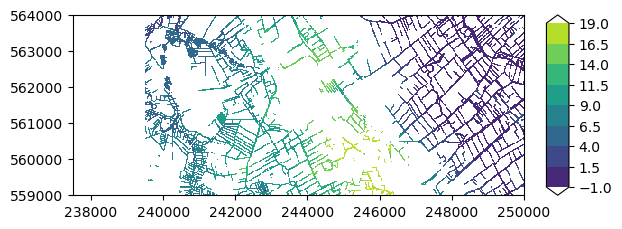

In [86]:
imod.visualize.plot_map(
    new_riv_ds["stage"].max(dim="layer"), "viridis", np.linspace(-1, 19, 9)
)

Hmmmm, the western side of the river stage grid seems suspiciously inactive… <br>We have to contact our colleague later. For now, let’s work with what we have and update the model.

First we make a new reference ('gwf_model') to our groundwater model. Remeber that 'sim_Hondsrug' refers to the full MODFLOW6 simulation. <br>
With ``sim_Hondsrug["imported_model"]`` we can directely refer to the groundwater model within the simulation. <br> 
That makes editing easier. 

In [89]:
gwf_model = sim_Hondsrug["imported_model"]

Next step is that we remove the existing RIV element from the model before we add the new one.

In [90]:
old_riv = gwf_model.pop("rivriv")

Now we are ready to add the new RIV object.

In [91]:
gwf_model["new_riv"] = imod.mf6.River(**new_riv_ds)

Lets’s write the simulation with our updated model!

In [92]:
tmp_dir = imod.util.temporary_directory()

sim_Hondsrug.write(tmp_dir)

ValidationError: 
Simulation validation status:
	* imported_model model:
		* new_riv package:
			* stage:
				* not all values comply with criterion: >= bottom_elevation
			* conductance:
				* nodata is not aligned with stage
				* not all values comply with criterion: > 0.0
			* bottom_elevation:
				* nodata is not aligned with stage
			-> You might fix this by calling the package's ``.cleanup()`` method.

Oh no! Our river package has a completely inconsistent dataset. The model validation raises the following issues:
- The bottom elevation exceeds stage in some cells
- NoData cells are not aligned between stage and conductance
- NoData cells are not aligned between stage and bottom_elevation
- There are conductance values with value <= 0.0

We can also check where stage exceeds river bottom elevation using basic xarray functionality.

(<Figure size 640x480 with 2 Axes>, <Axes: >)

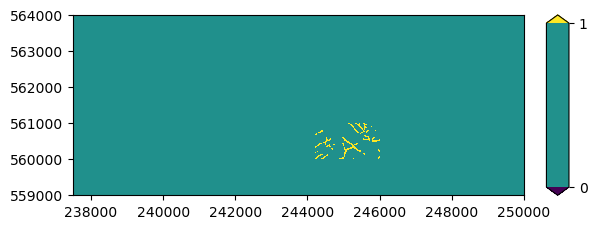

In [94]:
# calculate a difference grid with TRUE (1) and FALSE (2) values 
stage_above_riv_bot = new_riv_ds["stage"] < new_riv_ds["bottom_elevation"]

# plot the grid
imod.visualize.plot_map(stage_above_riv_bot.max(dim="layer"), "viridis", [0, 1])

So luckily the area affected by this error is only small. Let’s investigate the size of the error here.

In [95]:
diff = gwf_model["new_riv"]["bottom_elevation"] - gwf_model["new_riv"]["stage"]
max_diff = diff.max().values
max_diff

array(0.10000038)

A difference of 10 cm is not much but it will throw an error in MODFLOW6. <br> 
Let's make a copy of the dirty data. Because in the next steps we will clean up the data. 

In [96]:
# save incorrect riv data for comparison later
dirty_ds = gwf_model["new_riv"].dataset.copy()

We can now clean up the package. To clean up the River package, the method requires the model discretization, contained in the ``imod.mf6.StructuredDiscretization`` package. In this model, we named this package “dis”.

In [99]:
dis_pkg = gwf_model["dis"]
gwf_model["new_riv"].cleanup(dis=dis_pkg)

Let's also isolate the cleaned data (cleaned_ds)  from the River object in order to compare it with the dirty data (dirty_ds).

In [100]:
cleaned_ds = gwf_model["new_riv"].dataset

According to the method’s explanation (the method calls ``imod.prepare.cleanup_riv()``), the bottom elevation should be altered by the cleanup function.

Let’s first see if the stages were altered, we’ll calculate the difference between the original stage and cleaned version.

Text(0.5, 1.0, 'stage lowered by cleanup (m)')

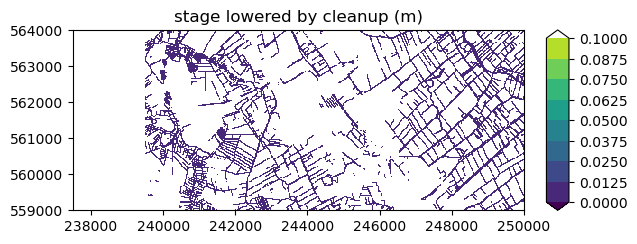

In [101]:
diff_stage = dirty_ds["stage"] - cleaned_ds["stage"]

fig, ax = imod.visualize.plot_map(
    diff_stage.max(dim="layer"), "viridis", np.linspace(0, max_diff, 9)
)
ax.set_title("stage lowered by cleanup (m)")

The stages are indeed not altered (all zero).

Let’s see if the bottom elevations are lowered, we’ll calculate the difference between the original bottom elevation and cleaned version.

Text(0.5, 1.0, 'river bottom lowered by cleanup (m)')

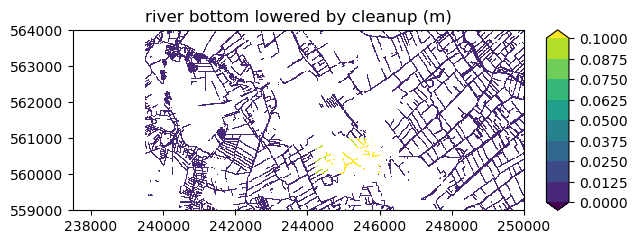

In [102]:
diff_riv_bot = dirty_ds["bottom_elevation"] - cleaned_ds["bottom_elevation"]

fig, ax = imod.visualize.plot_map(
    diff_riv_bot.max(dim="layer"), "viridis", np.linspace(0, max_diff, 9)
)
ax.set_title("river bottom lowered by cleanup (m)")


You can see the bottom elevation was lowered by the cleanup method. Furthermore the area in the west where no active stages were defined are also deactivated.

We advice to always verify if the data is cleaned in a manner that fits your use-case. For example, you might need to raise the stages to the river bottom elevation, instead of lowering the latter to the former like the cleanup method just did. In such case, you need to manually fix the data.

The cleanup method helps getting your data through the model validation, but is not guaranteed to be the “best” way to clean up your data!

As a final check, let's write the model into MODFLOW6 files. <br> 
We do not expect a validation error now.......

In [103]:
tmp_dir = imod.util.temporary_directory()

sim_Hondsrug.write(tmp_dir)

## Regrid your model

Our groundwater model has a cellsize of 25 m. <br>
iMOD Python has the function ``regrid_like`` that enables the user to upscale and downscale a full groundwater model with all its components. <br> The function only needs a targed grid. We keep the model window as it is but rescale from 25m to 100m <br>

So first we open a prepared targetgrid. A noce example of the function to open also ASC files.

In [104]:
Scalename= tutorialdir / "dbase" / "regrid" / "targed_scale.asc"
da = imod.rasterio.open(Scalename)

With a simpel command, we can create a new model object. <br> We call the new model 'sim_Hondsrug_regrid'. Is will have a cellsize of 100m. 

In [105]:
sim_Hondsrug_regrid = sim_Hondsrug.regrid_like("hondsrug_regrid", da, False)
sim_Hondsrug_regrid["imported_model"]["new_riv"].cleanup(sim_Hondsrug_regrid["imported_model"]["dis"])

You see, regridding might take some time. <br> Let's plot the Rivers data of both models and check the regridding. 

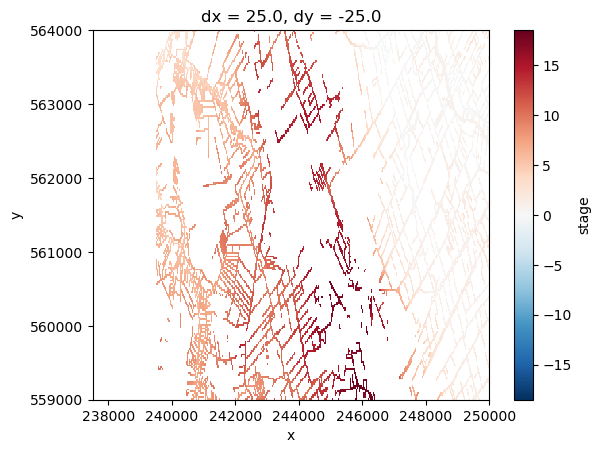

In [106]:
sim_Hondsrug["imported_model"]["new_riv"]["stage"].max(dim="layer").plot()

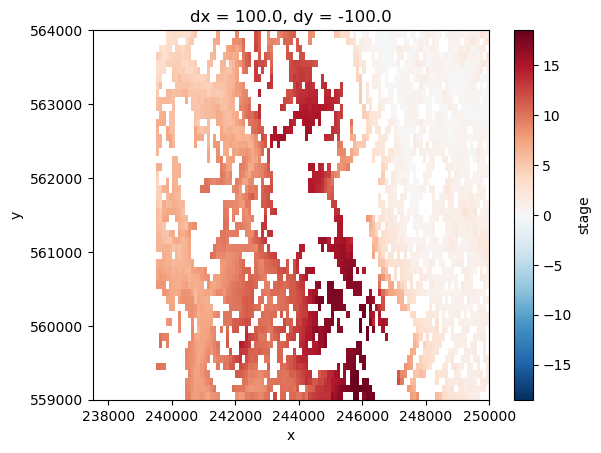

In [107]:
sim_Hondsrug_regrid["imported_model"]["new_riv"]["stage"].max(dim="layer").plot()

A perfect example of a regridded model. <br> Now we come to the last exercise.  


# Extra exercise - create Pandamesh network

In [108]:
import imod
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as sg
import pandamesh as pm
import xugrid as xu

We prepared for you an ESRI shape file with polygons defining 4 detailed zones within our model area. <br>
In the next step we load this shape as a Geopandas dataframe and plot it.

<Axes: >

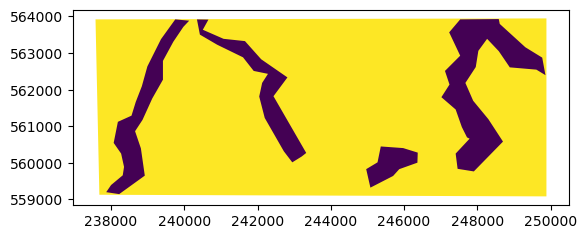

In [109]:
Zonename = tutorialdir / "dbase" / "Pandamesh" / "Regrid_zones.shp"
gdf = gpd.read_file(Zonename)
gdf.plot("cellsize")

The polygons might overlap causing errors during the preparation of a new unstructured network. <br>
In Pandamesh there is the function ``Preprocessor`` to clean the polygons and make them perfectly fit. <br>
We cal the new cleaned dataframe 'resolved'. 

In [110]:
resolved = (
    pm.Preprocessor(geometry=gdf.geometry, values=gdf.cellsize)
    .unify_polygons()
    .to_geodataframe()
).rename(columns={"values": "cellsize"})

If we plot this new dataframe, you see that the 5 polygons fit together like puzzle pieces.

<Axes: >

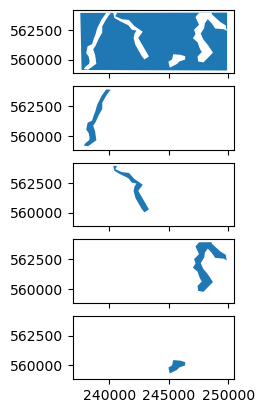

In [111]:
fig, (ax0, ax1, ax2 , ax3, ax4) = plt.subplots(nrows=5, sharex=True, sharey=True)
resolved.iloc[[0]].plot(ax=ax0)
resolved.iloc[[1]].plot(ax=ax1)
resolved.iloc[[2]].plot(ax=ax2)
resolved.iloc[[3]].plot(ax=ax3)
resolved.iloc[[4]].plot(ax=ax4)

Pandamesh uses external functions to create a triangle network. 

In [112]:
mesher = pm.TriangleMesher(resolved)
grid = mesher.generate_ugrid()

Let's plot the result.

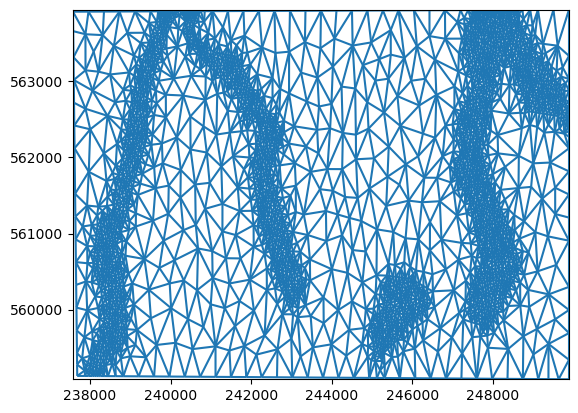

In [113]:
grid.plot()

And from this triangle network a voronoi network can be created. <br> In groundwater modelling voronoi grids have some advantages over triangle grids. 

We first create the voronoi grid.

In [114]:
vor_grid = grid.tesselate_centroidal_voronoi()

And then plot it.

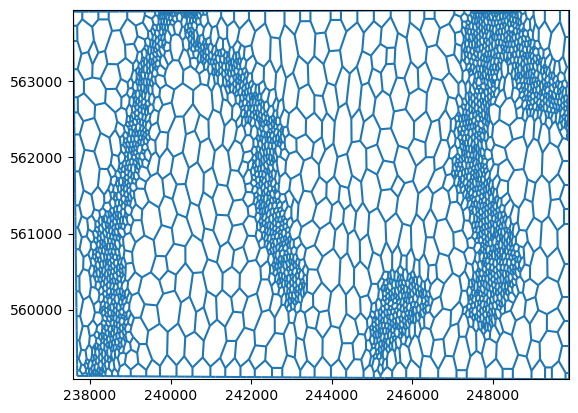

In [115]:
vor_grid.plot()

Within a few weeks the iMOD Python ``regrid_like`` function is ready to regrid also a *structured* groundwater model into an *unstructured* model with a simple command. It will look like this: 

``sim_Hondsrug_vor = sim_Hondsrug.regrid_like("hondsrug_regrid", vor_grid, True)`` <br>


Thank you for your attention!